# TP 5 - Compression d'images par K-means et centres mobiles

**Étudiantes :** Brenda TIDJET, Safa Leila BENNABI 



Dans cet exercice, on cherche à réduire le nombre de couleur d’une image pour la compresser.

### Données

Les données relatives à cet exercice sont à télécharger sur le cours Eureka sous forme d’un fichier compacté zip `Données de l’exercice sur le clustering`. 

Il contient notamment un fichier image tiff de 538×538 pixels nommé `bird_large.tiff` :

![image bird_large](data/bird_large.png)

Cette image est au format 24-bits avec des couleurs codées en RVB (RGB en angais), correspondant à la combinaison de l'intensitée de 3 couleurs de base : rouge, vert et bleu. L'intensité pour chacune de ces couleurs varie entre 0 et 255, nécessitant 1 octet (i.e. 8-bits), soit 16 millions de couleurs possibles.

L’objectif est de réduire ce nombre de couleurs utilisées dans l'image à seulement 16 couleurs et donc de compresser l’image.

On va utiliser pour cela un algorithme K-means. On va calculer 16 couleurs correspondant au centre de centroïds. Et on va remplacer la couleur de chaque pixel par la couleur du centroïd qui en est la plus proche.

Pour réduire le temps de calcul du à la manipulation de l'image au format 538x538 pixels, on va déterminer ces clusters de couleurs en utilisant une image plus petite : `bird_small.tiff` au format 128×128 pixels. Ensuite, on appliquera cette définition des couleurs sur la grande image.

On peut charger l’image par le code :

    import matplotlib.image as mpimg
    import numpy as np
    img = mpimg.imread("bird_small.tiff")
    

`img` est alors une matrice à 3 dimensions contenant la position du pixel pour les deux premiers indices, et la valeur de la composante couleur indiquée par le troisième indice. Par exemple, `img[50, 33, 2]` donnera l'intensité de la troisième composante de couleur (bleu) du pixel à la position (50,33). 

On peut modifier la couleur du pixel de coordonnées (100,120) de la manière suivante :

    img[100, 120] = (56, 120, 355)
    
La couleur de ce pixel sera codée par (rouge=56, vert=120, bleu=355).

Le but est d’identifier 16 centroids de clusters à partir de l'image. A chaque centroïd $j$, une couleur est associé et correspond à un vecteur à 3 composantes selon le codage RVB :  
$\mu_j = [r_j,v_j,b_j]$.

Ci-dessous, on désigne par $x_i= [r_i,v_i,b_i]$, le vecteur couleur à 3 composantes RVB pour chaque pixel $i$ de l’image. Ainsi x est stockée sous la forme d’une matrice à 3 colonnes (une pour chaque composante) et à 128×128 lignes si l’on prend la petite image. 

De même, $\mu$ peut être vue comme une matrice de 16 lignes et 3 colonnes.

NB : on peut cependant continuer de fonctionner avec les coordonnées des pixels dans la matrice (fonctionner avec un indice de ligne, un indice de colonne), il faudra adapter l’algorithme ci-dessous.


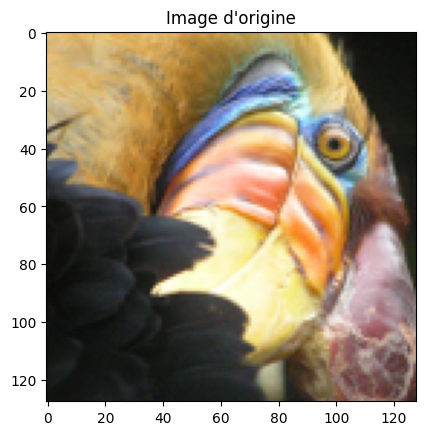

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

img = mpimg.imread("data/bird_small.tiff")

plt.imshow(img)
plt.title("Image d'origine")

plt.show()

In [25]:
def plot_centroids(centroids):
    
    if centroids.max() > 1.0:
        centroids = centroids / 255.0

    num_centroids = len(centroids)
    plt.figure(figsize=(10, 2))

    for i, centroid in enumerate(centroids):
        plt.subplot(1, num_centroids, i + 1)
        plt.imshow([[centroid]])
        plt.axis('off')
    
    plt.suptitle("Couleurs des centroïdes")
    plt.show()

### Algorithme K-means

1. Commencer par choisir aléatoirement 16 couleurs dans l’image pour caractériser les centroids initiaux, les k-means : $\mu_1, \mu_2, \dots, \mu_k$.

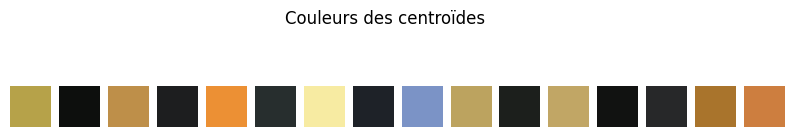

In [26]:
# tirer 16 pixel aléatoirement
pixels = img.reshape(-1, 3)
indices = np.random.choice(range(128*128), 16)
centroids = pixels[indices] # on obtient un tableau de 16x3 représentant les mu

plot_centroids(centroids)


2. Pour chacun des pixels $i$ dans l’image, trouver la valeur de couleur la plus proche parmis les $\mu_j$ et enregister l'indice du centroïd correspondant :

$$
c_i = \arg\min_j \parallel x_i − \mu_j \parallel ^2
$$

In [27]:
from scipy.spatial.distance import cdist
def rattachePixelAuCentroid(pixels, centroids):
    distances = cdist(pixels, centroids, 'euclidean')
    return np.argmin(distances, axis=1)

c_i = rattachePixelAuCentroid(pixels, centroids)    #cluster pour chaque pixel
print(c_i, c_i.shape)

[11 11 11 ... 13 13 13] (16384,)


3. Mettre à jour les couleurs $\mu_j$ associées à chacun des 16 centroids connaissant les pixels constituant les clusters (on recalcule la moyenne des couleurs des pixels qui appartiennent au même centroïde avec une formule de barycentre equipondéré) :
$$
\mu_j(j) = \frac{\sum_i 1\{c_i = j\}x_i}{\sum_i 1\{c_i = j\}}
$$
où $1\{\dots\}$ désigne la fonction indicatrice qui vaut 1 lorsque l'expression booléenne dans l'accolade est vraie et 0 sinon.

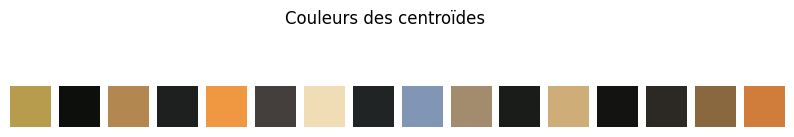

In [28]:
def recalculerCentroids(pixels, c_i, centroids):
    new_centroids = np.zeros_like(centroids)
    for j in range(len(centroids)):
        pixels_assignes = pixels[c_i==j]
        if len(pixels_assignes) > 0:
            new_centroids[j] = pixels_assignes.mean(axis=0) # barycentre
        else:
            new_centroids[j] = pixels[np.random.choice(range(128*128))]
    return new_centroids

new_centroids = recalculerCentroids(pixels, c_i, centroids)

plot_centroids(new_centroids)

4. Répéter les étapes 2 et 3 jusqu’à la convergence (entre 30 et 100 itérations). Deux possibilités : soit fixer le nombre d’itérations au départ de la boucle, soit entrer dans une boucle de laquelle on sort dès que les couleurs associées aux centroids sont stabilisées. 

NB 1 : commencer par un nombre fixe d’itérations avant de mettre au point la seconde alternative.

NB 2 : à l’étape 3, il est possible qu’un centroid ne possède aucun pixel, on risque alors une division par 0 ce qu’il faut détecter pour éviter cette situation. 

In [29]:
def compress_image(centroids, c_i, shape=(128, 128, 3)):
    compressed_pixels = centroids[c_i]
    compressed_pixels= np.clip(compressed_pixels,0,255).astype(np.uint8)
    compressed_img = compressed_pixels.reshape(shape)
    
    return compressed_img

In [30]:
# répéter un nombre fixe d'itérations
def kmeans_iter(pixels, centroids, nb_iter=100):
    for i in range(nb_iter):
        c_i = rattachePixelAuCentroid(pixels, centroids)
        centroids = recalculerCentroids(pixels, c_i, centroids)
        
         # Afficher l'image compressée toutes les 10 itérations
        if (i + 1) % 10 == 0:
            compressed_img = compress_image(centroids, c_i)
            plt.imshow(compressed_img)
            plt.title(f"Image compressée après {i + 1} itérations")
            plt.axis('off')
            plt.show()
    return centroids, c_i

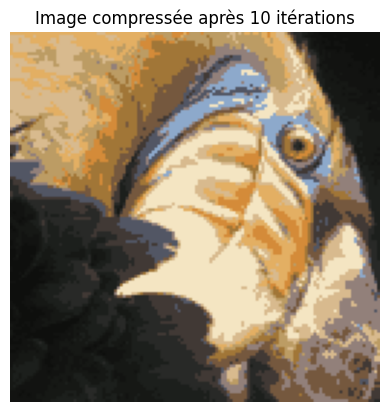

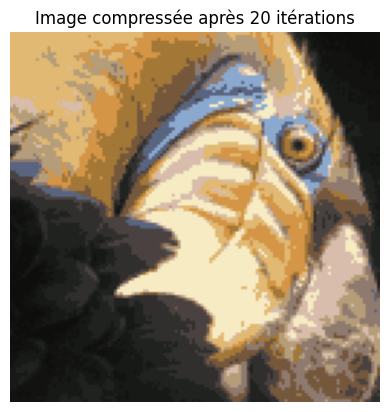

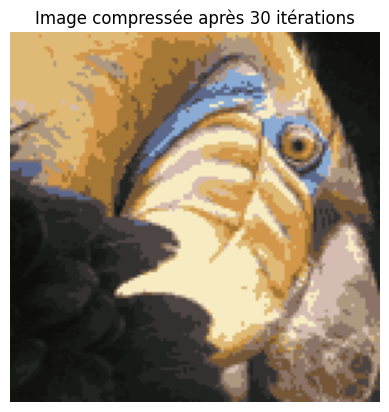

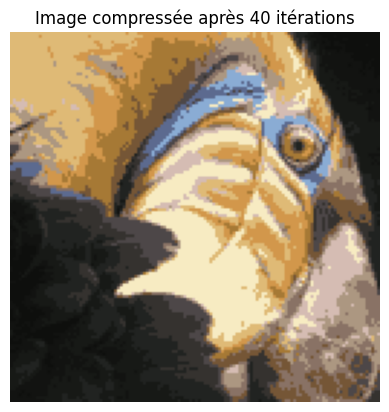

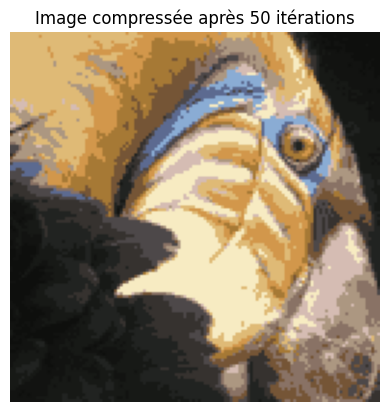

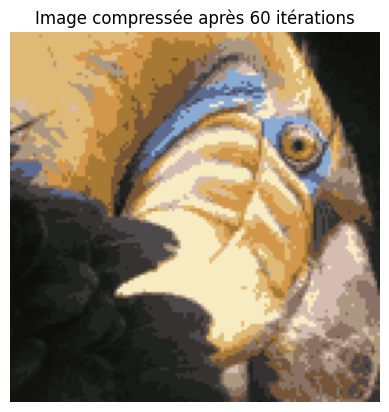

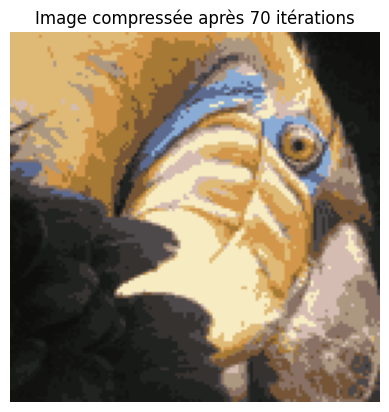

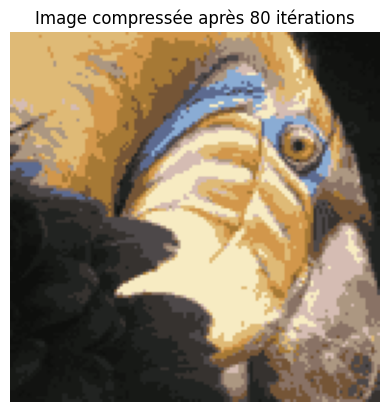

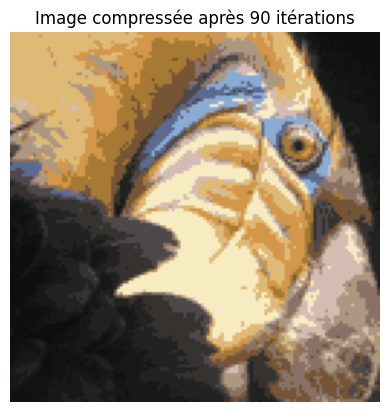

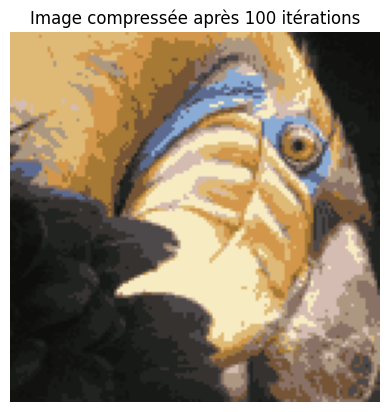

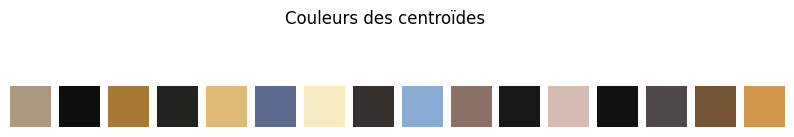

In [31]:
centroids, c_i = kmeans_iter(pixels, centroids)
plot_centroids(centroids)

In [32]:
def kmeans_stabilite(pixels, centroids, tol=1e-3):
    for i in range(1000):
        c_i = rattachePixelAuCentroid(pixels, centroids)
        new_centroids = recalculerCentroids(pixels, c_i, centroids)
        if np.allclose(centroids,new_centroids, atol=tol):
            print(f"Convergence atteinte à la convergence {i+1}")
            break
            
        centroids = new_centroids
        
        
    compressed_img = compress_image(centroids, c_i)
    plt.imshow(compressed_img)
    plt.title("Image compressée après convergence")
    plt.axis('off')
    plt.show()
    
        
    return centroids, c_i, i

Convergence atteinte à la convergence 1


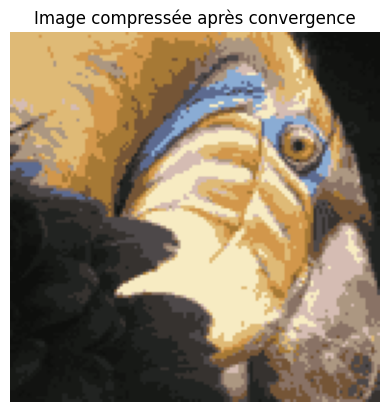

0


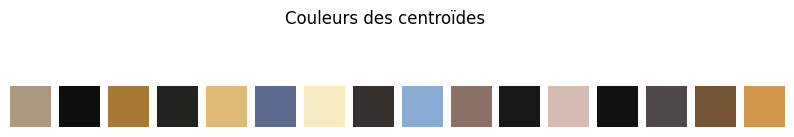

In [33]:
centroids, c_i, i = kmeans_stabilite(pixels, centroids)
print(i)
plot_centroids(centroids)

### Application à la grande image

Après la convergence de l’étape précédente, prendre la grande image et remplacer la couleur de chaque pixel par la couleur du centroïd la plus proche et calculée sur la petite image. Puis afficher l’image obtenue avec un code du type :

    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.show()

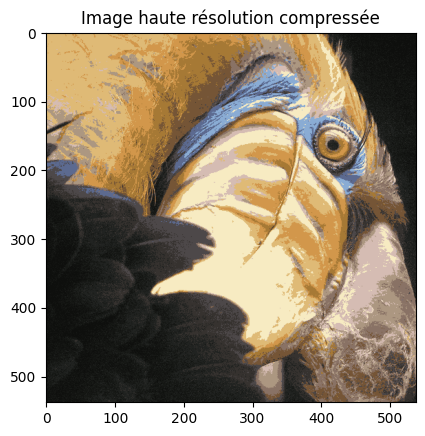

In [34]:
img_large = mpimg.imread("data/bird_large.tiff")
pixels_large = img_large.reshape(-1, 3)
c_i_large = rattachePixelAuCentroid(pixels_large, centroids)
compressed_img_large = compress_image(centroids, c_i_large, shape=(538, 538, 3))
plt.imshow(compressed_img_large)
plt.title("Image haute résolution compressée")
plt.show()